In [1]:
import numpy as np
from scipy.io import loadmat
import h5py

import matplotlib.pyplot as plt

### read csv
import pandas as pd
import os

import json

In [2]:
def read_data(file_path):
    with h5py.File(file_path, 'r') as file:
        print("Variables in file:")
        # List all groups (MATLAB variables are stored as groups in HDF5)
        for var_name in file:
            print(var_name)
        data = file[var_name][()]
    return data
    
def read_map(json_path):
    # json_path = '/scratch/cl7201/neuro_decode/Neuronexus_dataset/public/mapping.json'
    with open(json_path, 'r') as file:
        channel_map = json.load(file)
        print(channel_map)
    return channel_map

def read_csv(file_path, sheet_name=None):
    if sheet_name == None:
        # read all
        data = pd.read_excel(file_path)
    else:
        data = pd.read_excel(file_path, sheet_name=sheet_name)
    return data

    
def normalize(data):
    # check the range of each channel
    for i in range(data.shape[0]):
        # normalize
        # data = data.astype('float32')
        # print(np.mean(data[i]), np.std(data[i]))
        data[i] = (data[i] - np.mean(data[i])) / np.std(data[i])
        # print(np.max(data[i]), np.min(data[i]))
        # break
        
    return data


In [3]:
file_path1 = '/scratch/cl7201/neuro_decode/Neuronexus_dataset/AD_HF01_1/AD_HF01_1.mat'
file_path2 = '/scratch/cl7201/neuro_decode/Neuronexus_dataset/AD_HF02_2/AD_HF02_2.mat'

data1 = read_data(file_path1)
data2 = read_data(file_path2)

Variables in file:
data
Variables in file:
data


In [3]:
file_path3 = '/scratch/cl7201/neuro_decode/Neuronexus_dataset/NN_syn_01/NN_syn_01.mat'
data3 = read_data(file_path3)

Variables in file:
data


In [4]:
channel_map = read_map('/scratch/cl7201/neuro_decode/Neuronexus_dataset/public/mapping.json')


{'phase-shift': 'UNK', 'phase shift': 'UNK', 'CA1|DG': 'CA1', 'DG ml': 'DG', 'phaseshift': 'UNK', 'unknown/thalamus': 'UNK', 'CA1 ': 'CA1', 'CA1 slm': 'CA1', 'CA1/DG': 'CA1', 'DG ': 'DG', 'unknown': 'UNK', 'DG/CA3': 'DG', 'DG /CA3': 'DG', 'unknown/wrong rad': 'UNK', 'DG/CA1': 'DG', 'CA3/DG': 'CA3', 'CA1/CA2 ': 'CA1', 'CA1/CA3': 'CA1', 'oriens': 'CA1', 'CA3|unknown': 'CA3', 'CA3 radiatum': 'CA3', 'CA3|CA2': 'CA3', 'radiatum': 'CA3'}


In [5]:


label1 = read_csv('/scratch/cl7201/neuro_decode/Neuronexus_dataset/public/Sinaps_Channel_Maps.xlsx', sheet_name='AD_HF01_Session1')
label2 = read_csv('/scratch/cl7201/neuro_decode/Neuronexus_dataset/public/Sinaps_Channel_Maps.xlsx', sheet_name='AD_HF02_Session2')
data1 = normalize(data1)
data2 = normalize(data2)

{'phase-shift': 'UNK', 'phase shift': 'UNK', 'CA1|DG': 'CA1', 'DG ml': 'DG', 'phaseshift': 'UNK', 'unknown/thalamus': 'UNK', 'CA1 ': 'CA1', 'CA1 slm': 'CA1', 'CA1/DG': 'CA1', 'DG ': 'DG', 'unknown': 'UNK', 'DG/CA3': 'DG', 'DG /CA3': 'DG', 'unknown/wrong rad': 'UNK', 'DG/CA1': 'DG', 'CA3/DG': 'CA3', 'CA1/CA2 ': 'CA1', 'CA1/CA3': 'CA1', 'oriens': 'CA1', 'CA3|unknown': 'CA3', 'CA3 radiatum': 'CA3', 'CA3|CA2': 'CA3', 'radiatum': 'CA3'}


In [5]:
data3.shape

(1024, 600000)

In [6]:
label3 = read_csv('/scratch/cl7201/neuro_decode/Neuronexus_dataset/public/Sinaps_Channel_Maps.xlsx', sheet_name='NN_Syn_20230601')
data3 = normalize(data3)

/tmp/ipykernel_700944/1458020278.py:32: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - np.mean(data[i])) / np.std(data[i])


In [7]:
def label_data(label, channel_map):
    # reorganize channel index - label mapping 
    # constrcuct an array of string, each channel index has a string label
    channel_index_label = []
    for i in range(1024):
        # find shank
        shank = i // 128 
        # column is 2* shank th column
        column = 2 * shank + 1
        row = 128 - i % 128 - 1
        # # find the label
        a = label.iloc[row, column]
        # replace label with channel mapped label
        if a in channel_map:
            a = channel_map[a]
        
        channel_index_label.append(a)

    # unique of the label
    unique_label = np.unique(channel_index_label)
    print(unique_label)
    return channel_index_label, unique_label


def plot_data(data, channel_index_label, color_map, label_map):
    # Define the sampling rate and the window of interest in milliseconds
    sampling_rate = 20000  # Hz: 1s how many samples?
    window_length_ms = 500

    # Calculate the number of samples to cover the window of interest
    window_length_samples = int(window_length_ms * sampling_rate / 1000)  # Convert ms to samples

    # Assuming we want to plot the first 500 ms of data
    start_sample = 0
    end_sample = start_sample + window_length_samples

    # Extract the window of data for plotting
    data_to_plot = data[:, start_sample:end_sample]

    # Separate the data into 8 shanks of 128 channels each
    shanks = [data_to_plot[i*128:(i+1)*128, :] for i in range(8)]

    # Plotting
    fig, axes = plt.subplots(1, 8, figsize=(20,15), sharex=True)

    for shank_index, shank_data in enumerate(shanks):
        ax = axes[shank_index]
        for channel_index in range(shank_data.shape[0]):
            # Offset each channel for visual clarity
            offsets = channel_index * np.max(np.abs(shank_data))
            # offsets = channel_index * 5
            channel_index_i = channel_index + shank_index * 128
            if channel_index_label[channel_index_i] in color_map:
                ax.plot(shank_data[channel_index] + offsets, color=color_map[channel_index_label[channel_index_i]])
        # set no border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.set_title(f'Shank-{shank_index + 1}')
        ax.set_yticks([])
        ax.set_xlim([0, window_length_samples])

    # Set the xlabel for the last subplot
    axes[-1].set_xlabel('Time (ms)')

    # Show the plot
    plt.tight_layout()
    # put legend right upper corner
    plt.legend(handles=[plt.Line2D([0], [0], color=color, label=label_map[label]) for label, color in color_map.items()], loc='upper right')
    plt.show()  

In [8]:
color_map = {
    "cortex": "red",
    "CA1": "orange",
    "CA3": "blue",
    "CA2": "green",
    "DG": "pink",
    "UNK": "black"
}
label_map = {
    "UNK": "UNK",
    "DG": "DG",
    "CA1": "CA1",
    "CA3": "CA3",
    "CA2": "CA2",
    "cortex": "cortex"
}


In [34]:
channel_index_label1, unique_label = label_data(label1)
channel_index_label2, unique_label = label_data(label2)
plot_data(data1, channel_index_label1, color_map, label_map)

plot_data(data2, channel_index_label2, color_map, label_map)

NameError: name 'label1' is not defined

['CA1' 'CA2' 'CA3' 'DG' 'UNK' 'cortex']


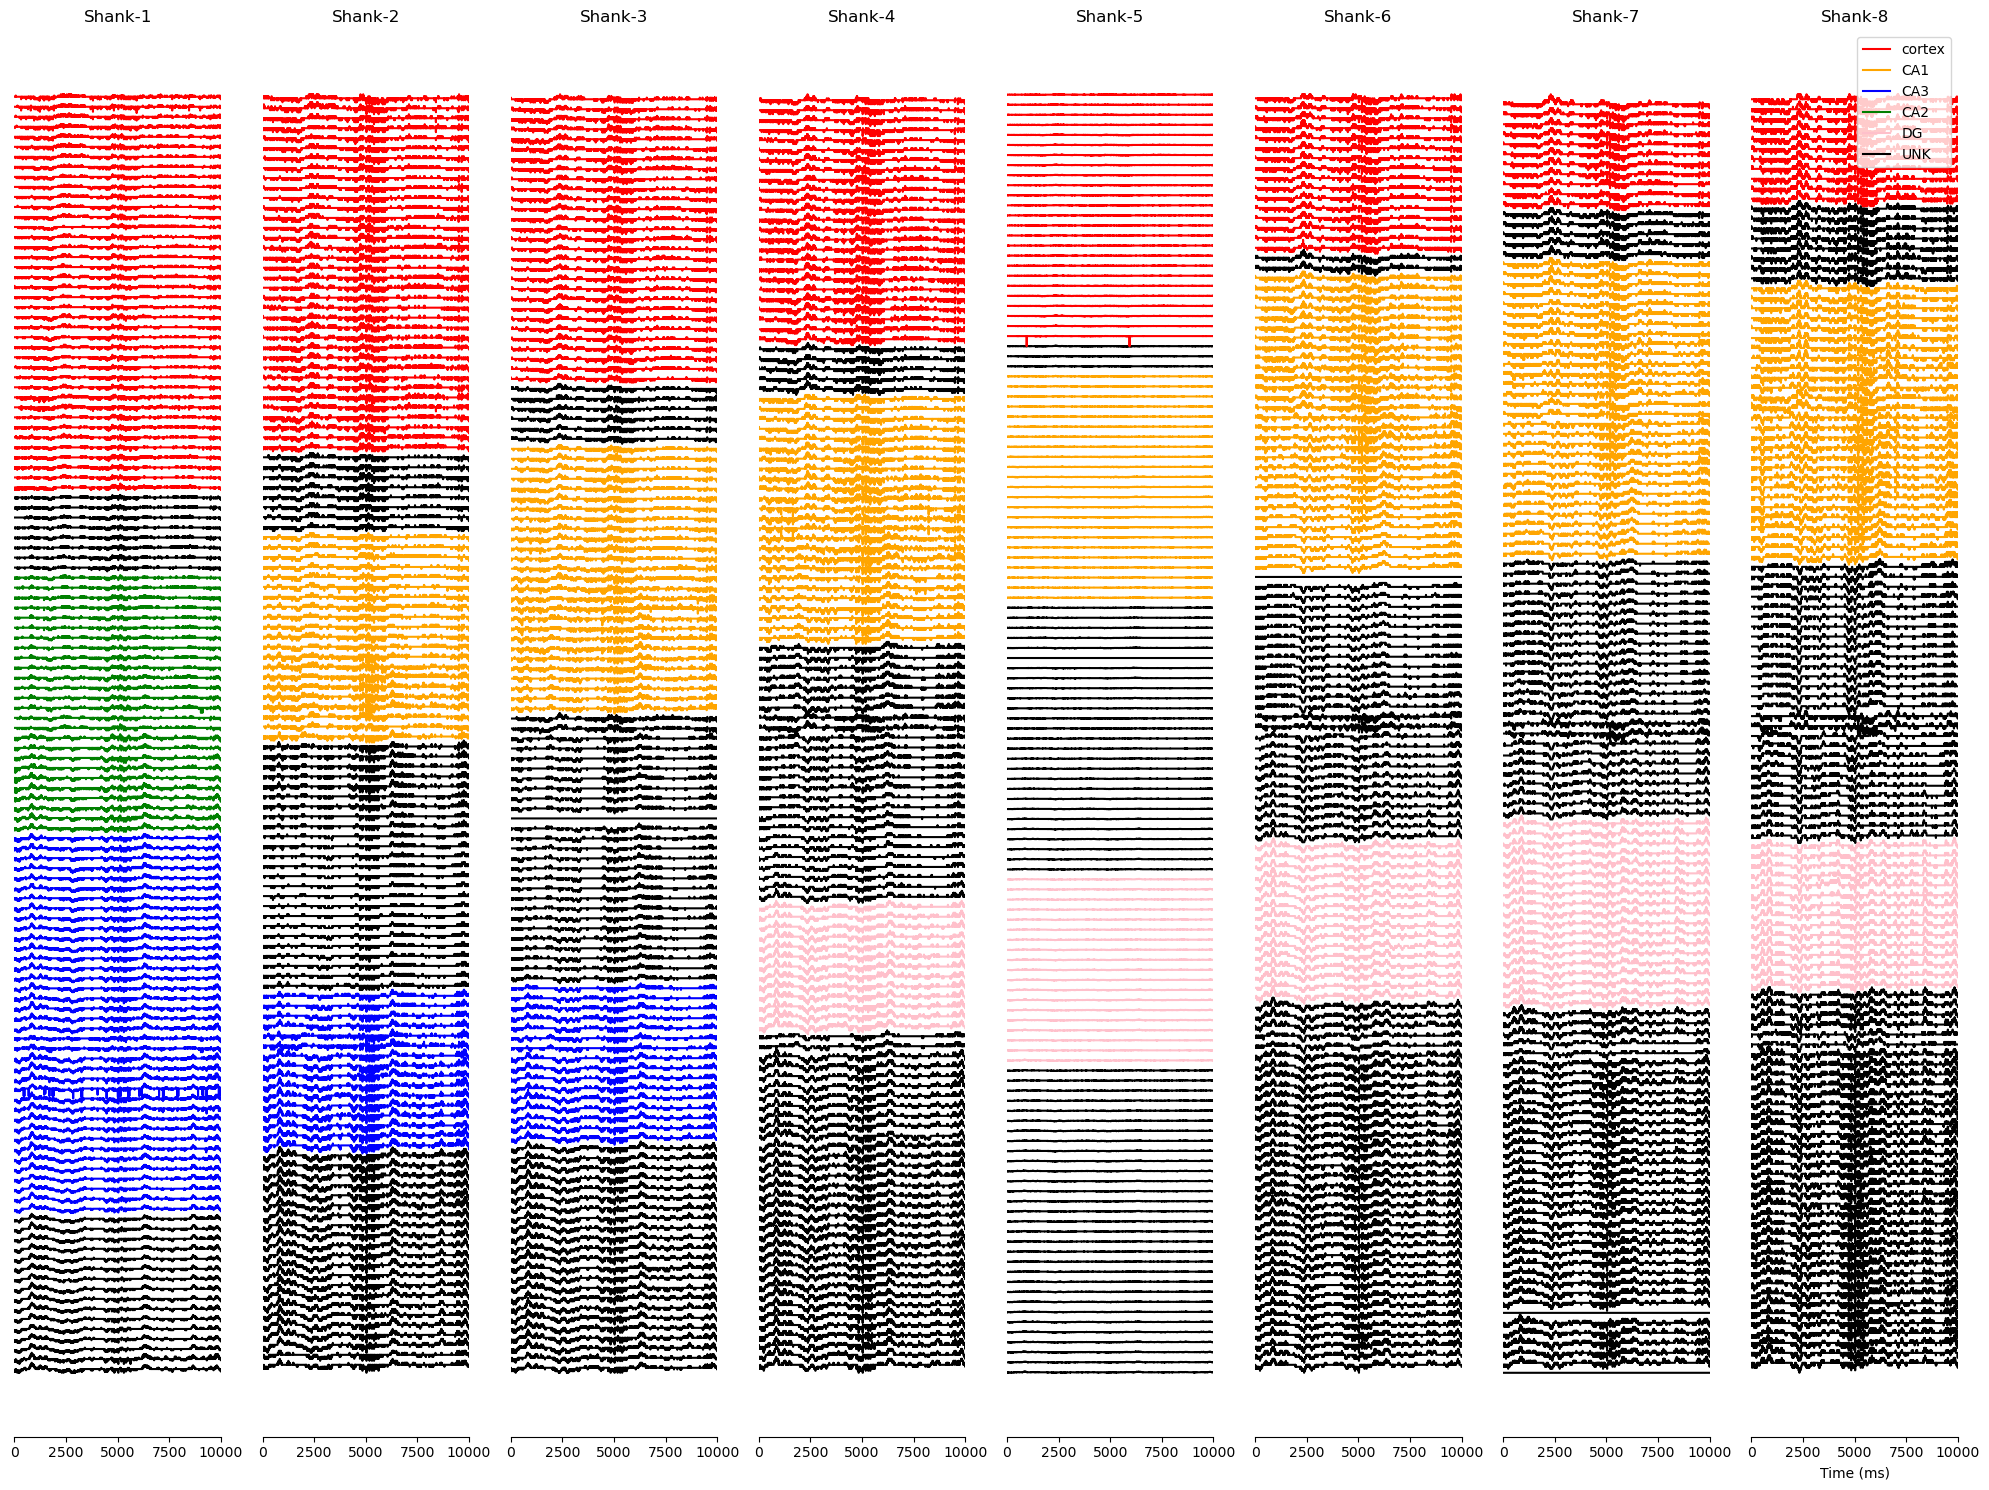

In [9]:
channel_index_label3, unique_label = label_data(label3, channel_map)
plot_data(data3, channel_index_label3, color_map, label_map)


In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import umap


/home/cl7201/.conda/envs/neuro_decode/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def reduction(data, channel_index_label, label, method="PCA"):
    if method=="PCA":
        pca = PCA(n_components=3)

        # Fit PCA on the dataset and transform the data
        transformed_data = pca.fit_transform(data)

    elif method=="umap":
        reducer = umap.UMAP(n_components=3, random_state=42)

        # Fit UMAP on the dataset and transform the data
        transformed_data = reducer.fit_transform(data)

    
    colors = [color_map.get(label, "gray") for label in channel_index_label]
    fig = go.Figure(data=[go.Scatter3d(
        x=transformed_data[:, 0],
        y=transformed_data[:, 1],
        z=transformed_data[:, 2],
        mode='markers',
        marker=dict(
            size=2, # Adjust the size of the points here
            color=colors, # Use the colors mapped from the labels
        )
    )])

    # Update layout for a better look
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title='c1',
            yaxis_title='c2',
            zaxis_title='c3'
        )
    )


    fig.show()
    return transformed_data
        

In [16]:
reduction(data1, channel_index_label1, label1, method="PCA")

In [18]:
reduction(data3, channel_index_label3, label3, method="PCA")

In [19]:

pca = PCA(n_components=3)

# Fit PCA on the dataset and transform the data
transformed_data1 = pca.fit_transform(data1)
transformed_data2 = pca.fit_transform(data2)
transformed_data3 = pca.fit_transform(data3)



In [22]:
# Create a 3D scatter plot using plotly

colors1 = [color_map.get(label, "gray") for label in channel_index_label1]
colors2 = [color_map.get(label, "gray") for label in channel_index_label2]
colors3 = [color_map.get(label, "gray") for label in channel_index_label3]

fig = go.Figure()

# Add subject 1 data to the plot with 'o' marker
fig.add_trace(go.Scatter3d(
    x=transformed_data1[:, 0],
    y=transformed_data1[:, 1],
    z=transformed_data1[:, 2],
    mode='markers',
    marker=dict(
        symbol='circle',
        size=2,
        color=colors2,  # Use the first part of the colors for subject 1
    ),
    name='Subject 1'
))

# Add subject 2 data to the plot with 'x' marker
fig.add_trace(go.Scatter3d(
    x=transformed_data2[:, 0],
    y=transformed_data2[:, 1],
    z=transformed_data2[:, 2],
    mode='markers',
    marker=dict(
        symbol='x',
        size=2,
        color=colors1,  # Assuming the same labels for simplicity; adjust as needed
    ),
    name='Subject 2'
))

    # Add subject 2 data to the plot with 'x' marker
fig.add_trace(go.Scatter3d(
    x=transformed_data3[:, 0],
    y=transformed_data3[:, 1],
    z=transformed_data3[:, 2],
    mode='markers',
    marker=dict(
        symbol='diamond',
        size=2,
        color=colors1,  # Assuming the same labels for simplicity; adjust as needed
    ),
    name='Subject 3'
))


# Update layout for a better look
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='c 1',
        yaxis_title='c 2',
        zaxis_title='c 3'
    )
)

fig.show()

In [23]:
reduction(data1, channel_index_label1, label1, method="umap")




/home/cl7201/.conda/envs/neuro_decode/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [24]:
reduction(data3, channel_index_label3, label3, method="umap")

/home/cl7201/.conda/envs/neuro_decode/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Train-Test MLP

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [13]:
pca = PCA(n_components=3)
transformed_data3 = pca.fit_transform(data3)


In [14]:
x = []
y = []
label_index = {'CA1':0,
 'CA2':1,
  'CA3':2,
   'DG':3,
   'cortex':4}
for i in range(len(channel_index_label3)):
    if channel_index_label3[i] == "UNK":
        continue
    x.append(transformed_data3[i])
    y.append(label_index[channel_index_label3[i]])
x = np.array(x)
y = np.array(y)
        

In [16]:
y.shape, x.shape

((555,), (555, 3))

torch.Size([444, 1, 3]) torch.Size([444, 1]) torch.Size([111, 1, 3]) torch.Size([111, 1])
Epoch [1/20], Loss: 1.6432
Epoch [2/20], Loss: 1.5592
Epoch [3/20], Loss: 1.4793
Epoch [4/20], Loss: 1.4972
Epoch [5/20], Loss: 1.4813
Epoch [6/20], Loss: 1.5114
Epoch [7/20], Loss: 1.4818
Epoch [8/20], Loss: 1.4894
Epoch [9/20], Loss: 1.5455
Epoch [10/20], Loss: 1.4791
Epoch [11/20], Loss: 1.4856
Epoch [12/20], Loss: 1.5232
Epoch [13/20], Loss: 1.5512
Epoch [14/20], Loss: 1.4813
Epoch [15/20], Loss: 1.5240
Epoch [16/20], Loss: 1.4797
Epoch [17/20], Loss: 1.5008
Epoch [18/20], Loss: 1.5523
Epoch [19/20], Loss: 1.4996
Epoch [20/20], Loss: 1.4827


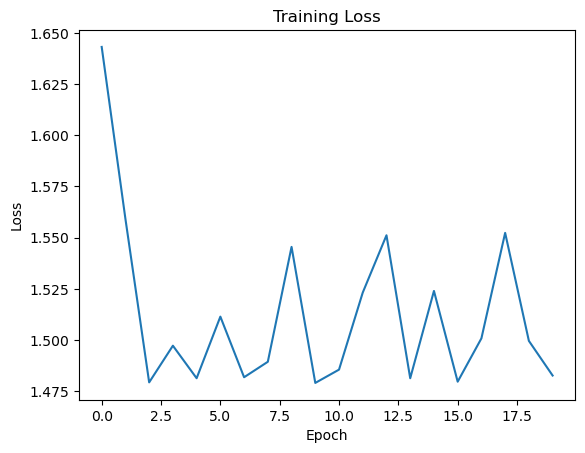

Accuracy of the model on the validation set: 38.73873873873874 %


In [44]:



# Example dataset (replace with your own data)
# X = torch.randn(1024, 3)  # Random data simulating your 1024x3 features
# y = torch.randint(0, 2, (1024,))  # Random binary labels, replace 2 with your number of classes

# Splitting dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.long).unsqueeze(1)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# Creating DataLoader for both training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    # softmax
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)

        return out

# Parameters
input_size = 3
hidden_size = 64 
num_classes = 5  # Adjust based on your number of classes
learning_rate = 0.001

# Initialize the MLP
model = MLP(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
# Training the model
num_epochs = 20 # You can adjust this
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        labels = labels.long().squeeze()
        features = features.squeeze()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item()) 
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Testing the model
model.eval()  # it sets the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in val_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the validation set: {} %'.format(100 * correct / total))


In [27]:
X_train[0].size

3